# Риск и распределение инвестиций в стартапы: расчёт объёма инвестиций

---

# Цель:
- Написать модель машинного обучения для:
    - рассчёта оптимального объёма инвестиций в стартап;
    - выявление признаков, влияющих на объём инвестиций;
    - сохранение модели для дальнейшего использования (расчёт объёма инвестиций).

In [34]:
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
plt.rcParams['figure.figsize'] = (8, 7)
%matplotlib inline
warnings.filterwarnings('ignore')

In [28]:
df = pd.read_csv('../data/processed/startup_investment_dataset+rejected_status.csv')

In [29]:
df = df[df['is_rejected'] == 0].drop(columns=['is_rejected'])
df.head()

,startup_stage,industry,region,requested_amount,pre_money_valuation,team_size,founders_experience_years,annual_revenue,market_size_estimate,investment_amount
1,Series B,HealthTech,US,7.784759e+06,3.049307e+07,13,8,9.608746e+04,6.886030e+07,7.203092e+06
4,Series B,E-commerce,US,1.608484e+07,5.189190e+07,10,7,1.336527e+05,1.415670e+07,1.672645e+07
6,Seed,AI/SaaS,Europe,2.492487e+06,1.805700e+07,8,3,1.760057e+05,1.159766e+07,1.598191e+06
7,Series A,FinTech,US,7.464134e+06,3.169615e+07,11,5,1.219577e+06,1.155930e+07,4.706876e+06
8,Series A,AI/SaaS,US,3.152825e+06,2.375383e+07,9,2,1.266550e+05,3.932326e+06,2.755136e+06


In [30]:
len(df)

1948

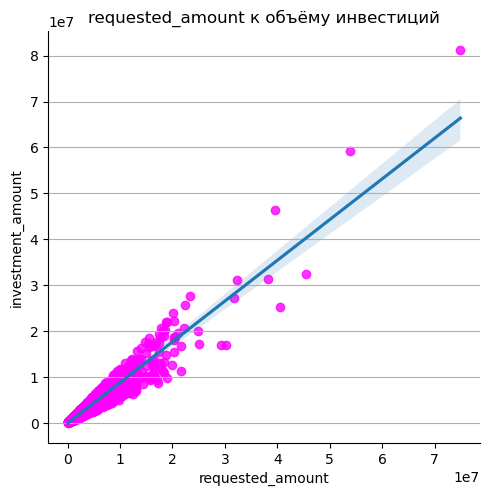

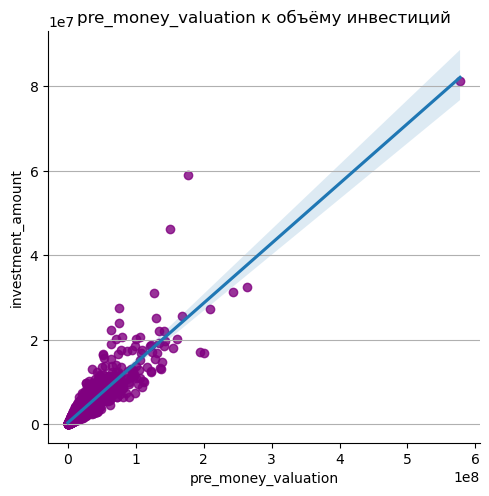

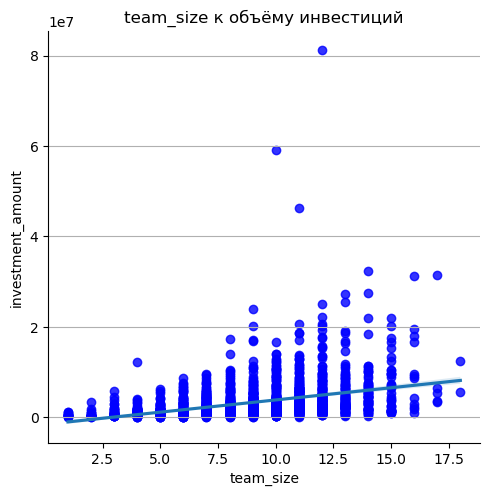

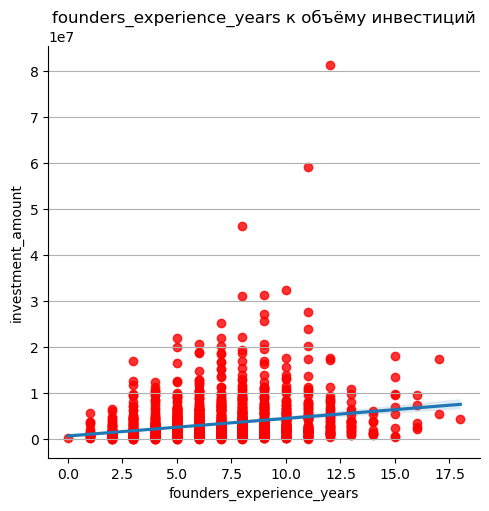

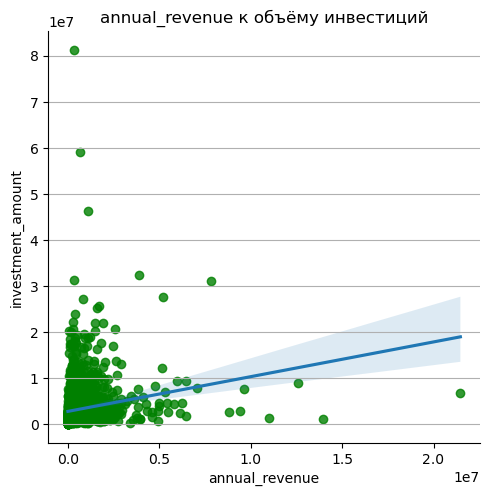

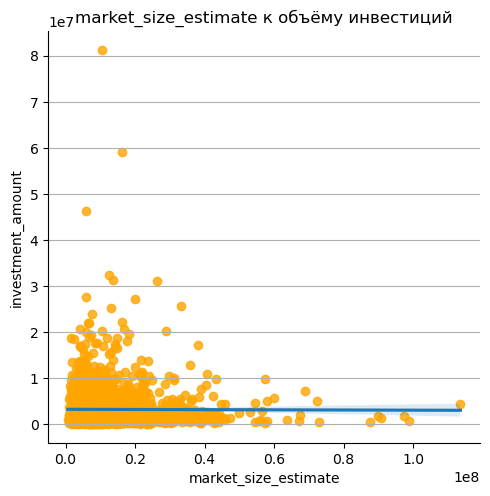

In [37]:
color_map = {
    'requested_amount': 'magenta',
    'team_size': 'blue',
    'annual_revenue': 'green',
    'market_size_estimate': 'orange',
    'pre_money_valuation': 'purple',
    'founders_experience_years': 'red'
}

for feature in df.select_dtypes(include=['int64', 'float64']).columns:
    if feature != 'investment_amount':
        sns.lmplot(
            data=df,
            x=feature,
            y='investment_amount',
            scatter_kws={'color': color_map.get(feature, 'gray')},
        )
        plt.grid(axis='y')
        plt.title(f'{feature} к объёму инвестиций')
        plt.show()